# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_shuffled"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

,task,acc,recall,precision,f1
0,ONE_VS_NINE__3VRL__auto__0__42,0.500501,0.507307,0.500494,0.503878
1,HIGH_VS_95LOW__3VRL__auto__0__42,0.495700,0.497000,0.495711,0.496355
2,HIGH_VS_LOOSER__3VRL__auto__0__42,0.500500,0.428200,0.500585,0.461572
3,ONE_VS_ONE__3VRL__1NSN__0__42,0.500300,0.526800,0.500285,0.513200
4,ONE_VS_ONE__3VRL__3RAJ__0__42,0.501600,0.511400,0.501569,0.506437


In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)

df["acc_closed"] = df["acc"].astype(float)

In [4]:
print(df.shape)
df.head()

(120, 12)


,task,acc,recall,precision,f1,ag_pos,ag_neg,seed_id,split_id,task_type,task_type_clean,acc_closed
0,ONE_VS_NINE__3VRL__auto__0__42,0.500501,0.507307,0.500494,0.503878,3VRL,auto,0,42,1v9,vs 9,0.500501
1,HIGH_VS_95LOW__3VRL__auto__0__42,0.495700,0.497000,0.495711,0.496355,3VRL,auto,0,42,high_vs_95low,vs Non-binder,0.495700
2,HIGH_VS_LOOSER__3VRL__auto__0__42,0.500500,0.428200,0.500585,0.461572,3VRL,auto,0,42,high_vs_looser,vs Weak,0.500500
3,ONE_VS_ONE__3VRL__1NSN__0__42,0.500300,0.526800,0.500285,0.513200,3VRL,1NSN,0,42,1v1,vs 1,0.500300
4,ONE_VS_ONE__3VRL__3RAJ__0__42,0.501600,0.511400,0.501569,0.506437,3VRL,3RAJ,0,42,1v1,vs 1,0.501600


## vs Non-binder, vs Weak, vs 9 performances

In [5]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [6]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

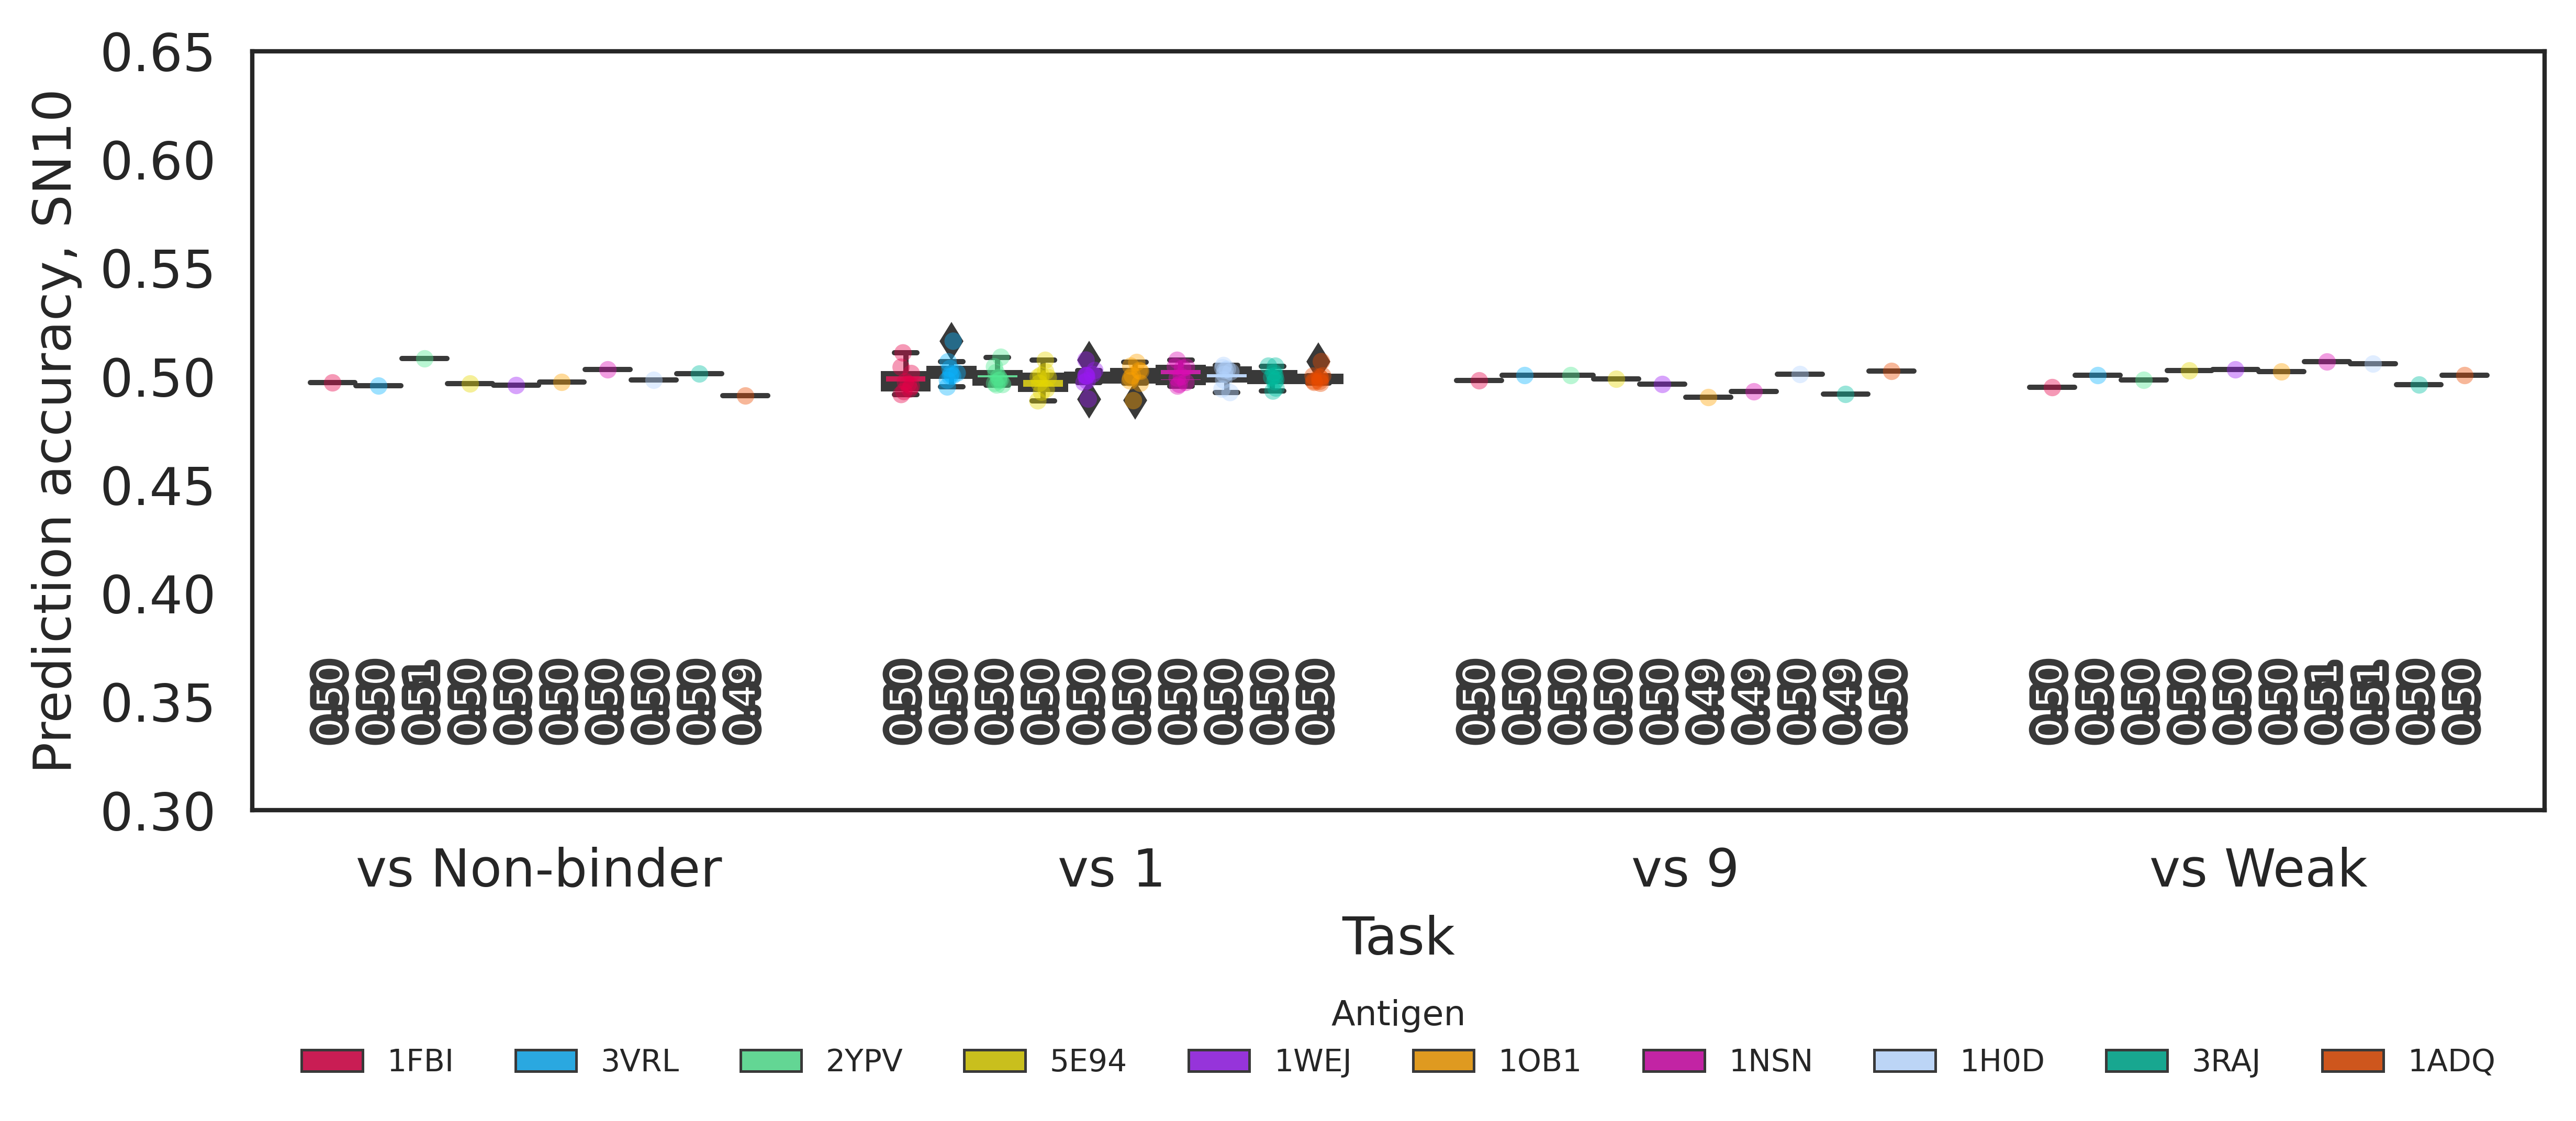

In [7]:
yticks = np.arange(0.3, 0.7, 0.05)
yaxis_title = "Prediction accuracy, SN10"
ag_order = visualisations.PlotParams.order_antigens
task_order = visualisations.PlotParams.order_tasks
task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

fig.show()

In [8]:
df.groupby("task_type")["acc_closed"].agg(["mean", "std"])

,mean,std
task_type,,
1v1,0.499919,0.004777
1v9,0.497337,0.004198
high_vs_95low,0.498520,0.004741
high_vs_looser,0.501170,0.003827


/tmp/ipykernel_48129/552326829.py:9: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(


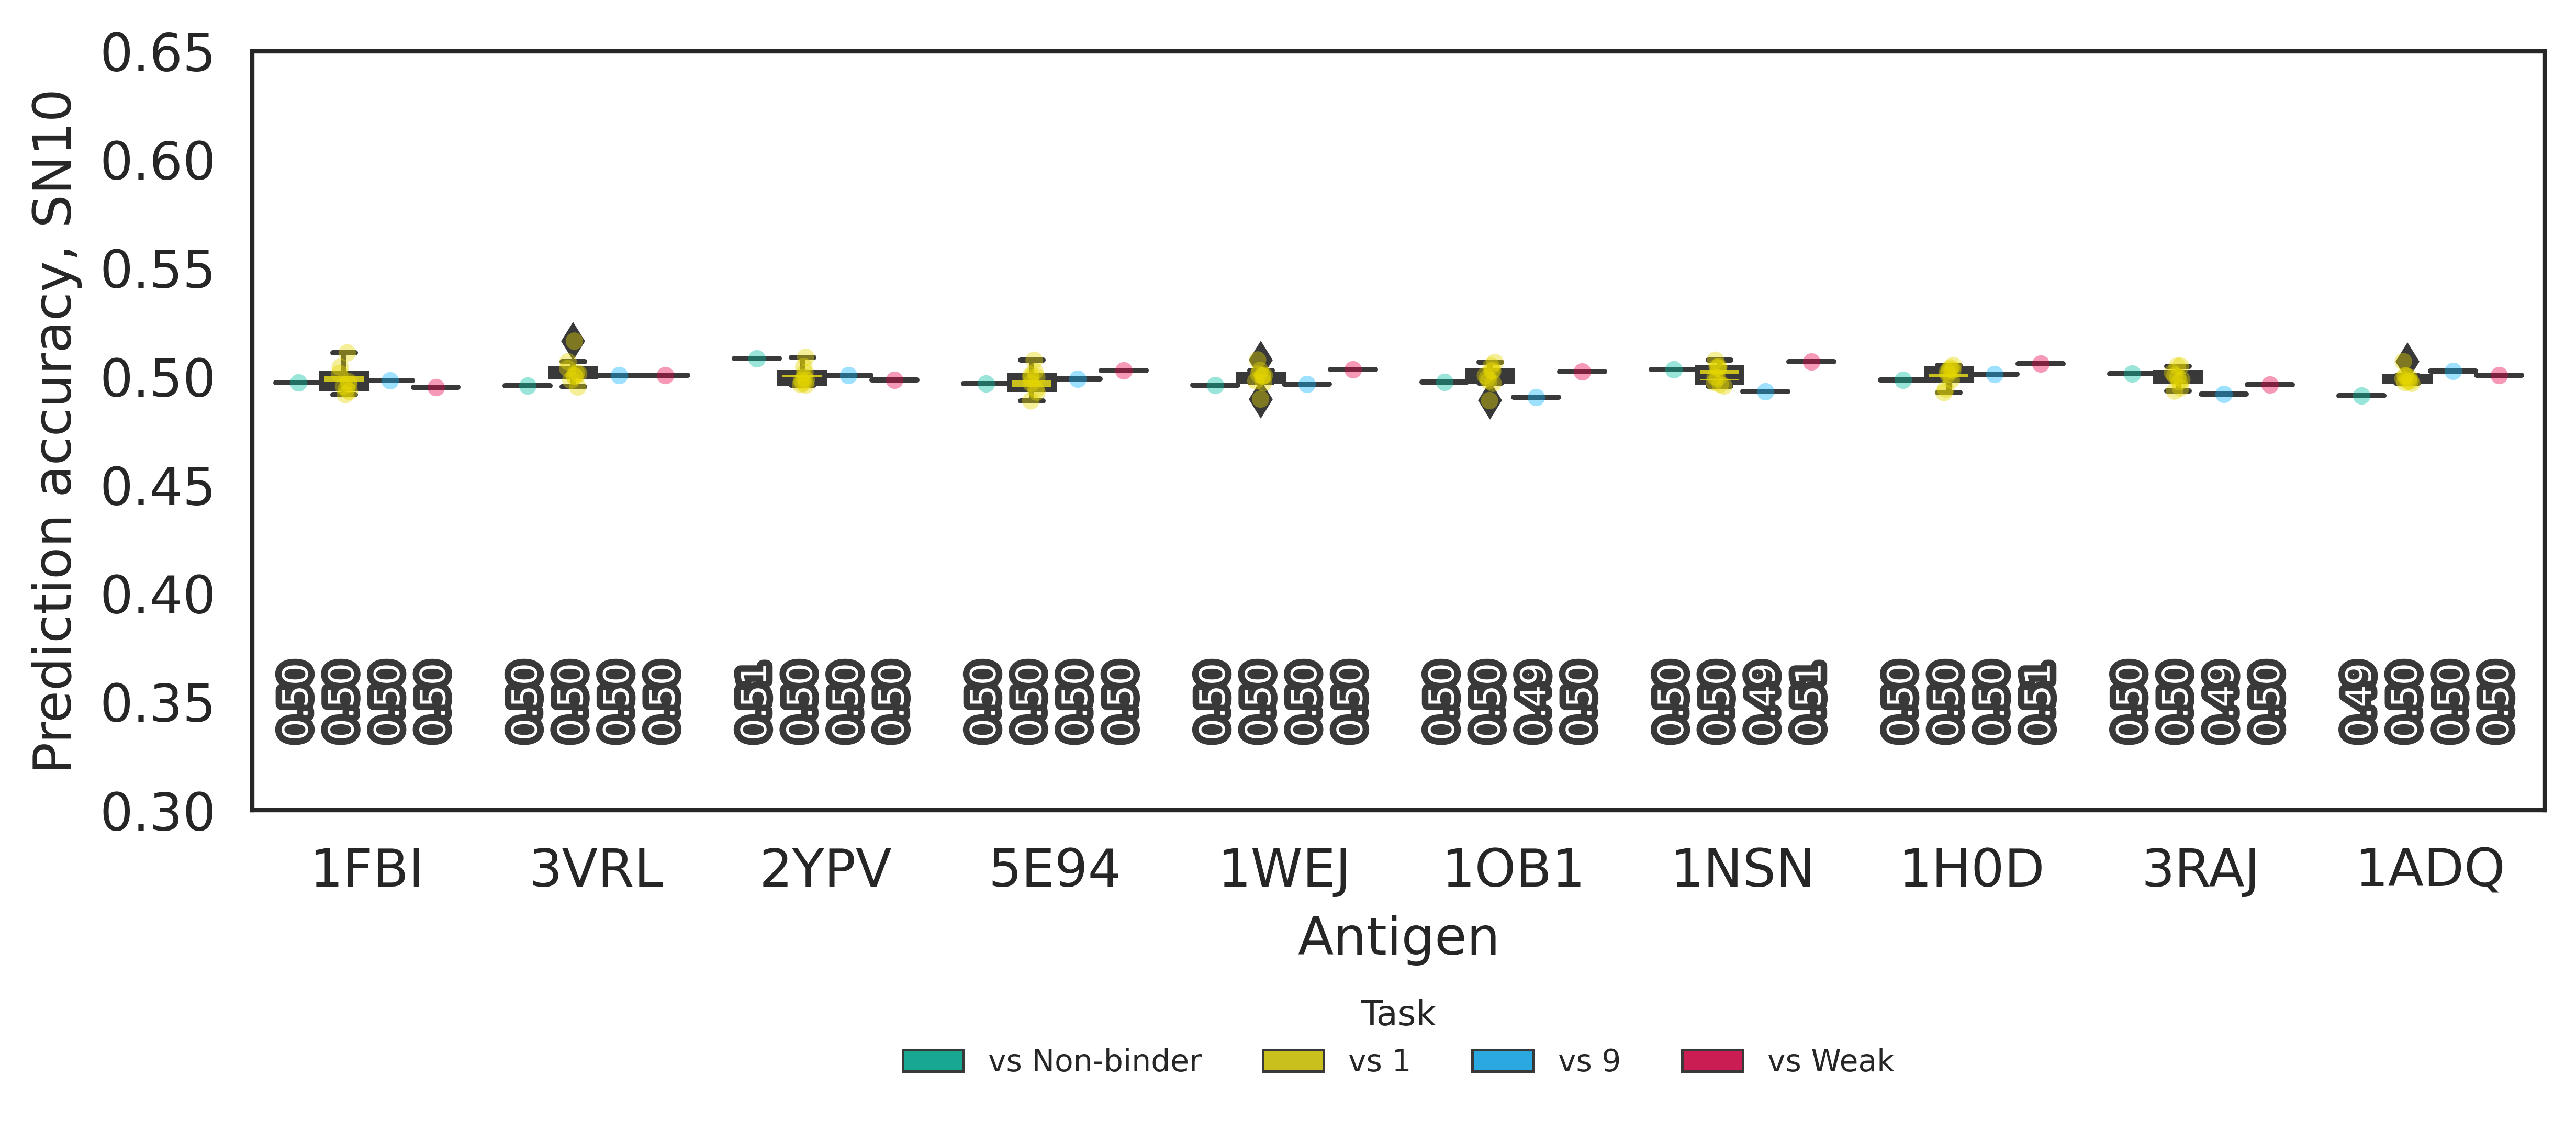

In [9]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [10]:
df.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ag_pos,,
3VRL,0.501692,0.005564
1NSN,0.500983,0.004678
1H0D,0.500750,0.004164
2YPV,0.500658,0.004428
1WEJ,0.499400,0.004492
1ADQ,0.499200,0.003707
1OB1,0.499174,0.005331
3RAJ,0.498741,0.004189
5E94,0.498358,0.004961


In [11]:
# Add mean and std, std rounded to 3 decimal places
df.groupby("task_type")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False).round(3).loc[
    task_order
]

,mean,std
task_type,,
high_vs_95low,0.499,0.005
1v1,0.500,0.005
1v9,0.497,0.004
high_vs_looser,0.501,0.004


## Entropy of slides

In [12]:
from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 

# Compute JSD for each task
loader = datasets.FrozenMiniAbsolutMLLoader(base_p)
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    
    try:
        loader.load(task, load_model=False)
    except:
        print(f"Failed to load {task_str}")
        raise

    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
    jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

vs 1
vs 1: r=0.15, p=0.17
vs 9
vs 9: r=0.38, p=0.28
vs Non-binder
vs Non-binder: r=-0.01, p=0.99
vs Weak
vs Weak: r=0.40, p=0.25


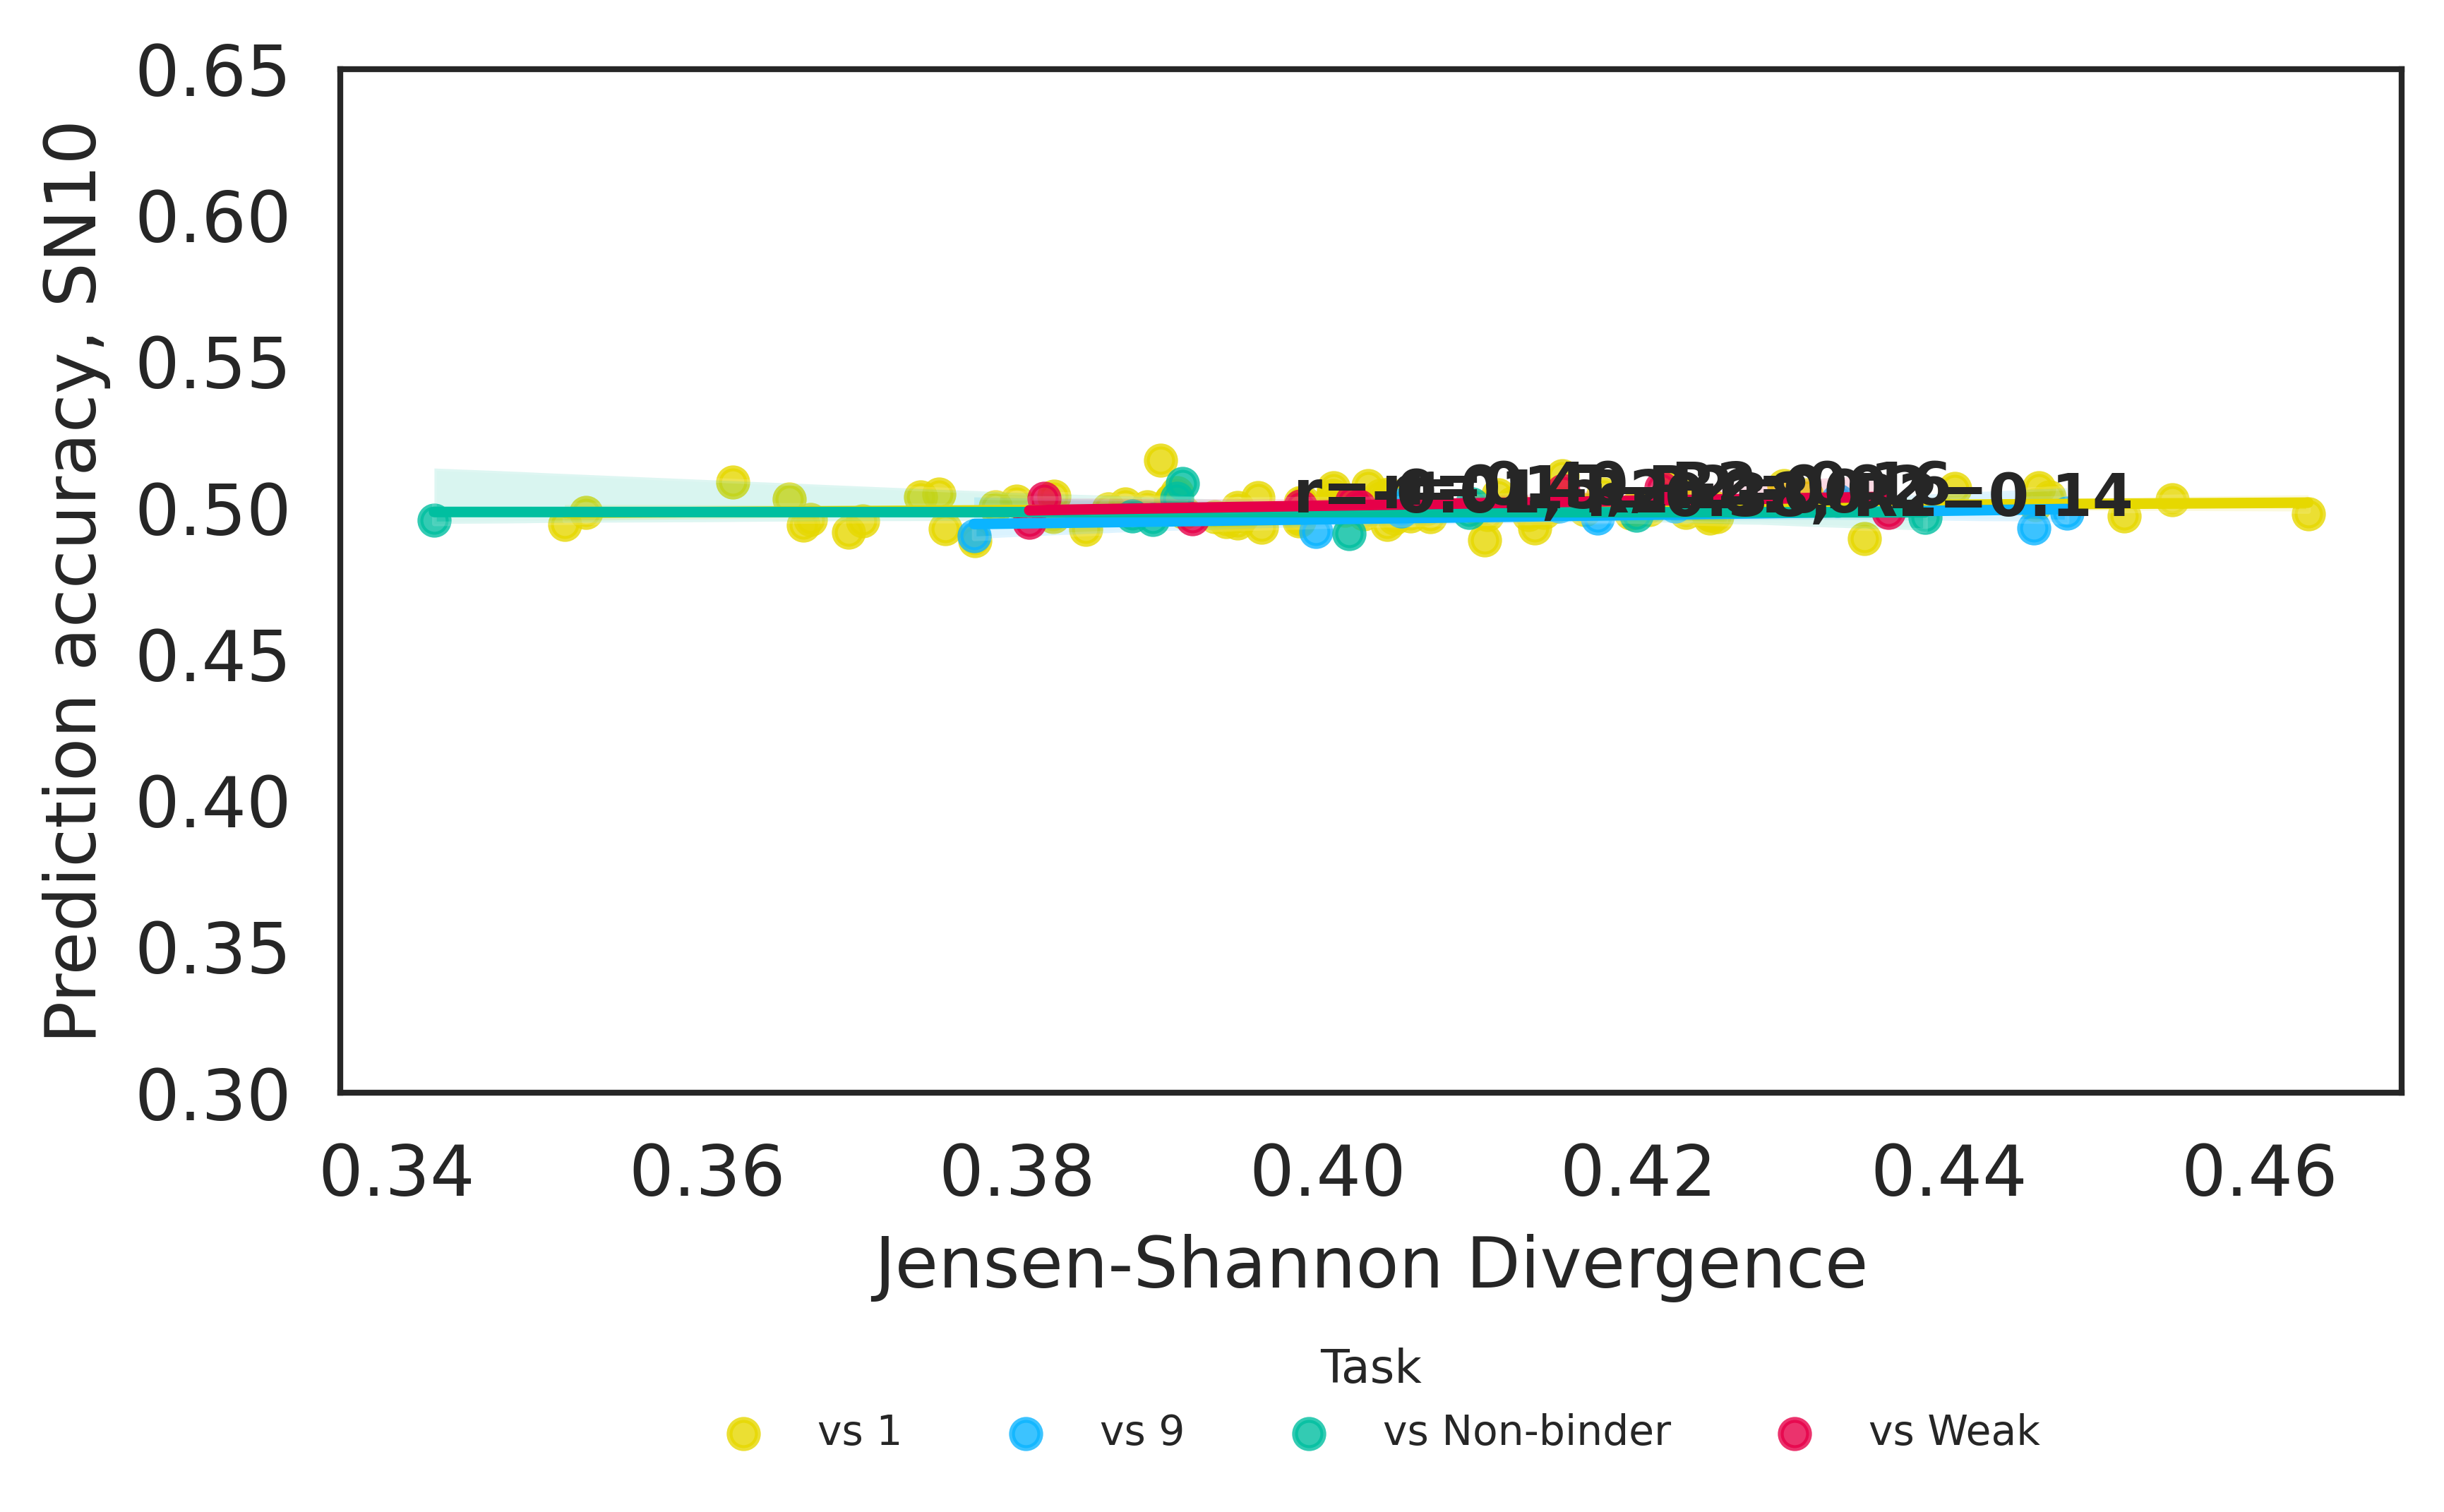

In [13]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for i, df_g in df.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

fig.savefig("figures/1B.svg")
fig.show()

In [14]:
for i, df_g in df.groupby("task_type_clean"):
    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")

vs 1: r=0.15, p=0.17
vs 9: r=0.38, p=0.28
vs Non-binder: r=-0.01, p=0.99
vs Weak: r=0.40, p=0.25


In [15]:
df.groupby("task_type_clean")["jsd"].agg(["mean", "std", "size"]).round(3).loc[task_clean_order]

,mean,std,size
task_type_clean,,,
vs Non-binder,0.398,0.025,10
vs 1,0.403,0.023,90
vs 9,0.417,0.022,10
vs Weak,0.405,0.018,10


In [16]:
df.groupby("task_type_clean").size()

task_type_clean
vs 1             90
vs 9             10
vs Non-binder    10
vs Weak          10
dtype: int64

## OOD

Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [17]:
df_o = pd.read_csv(f"{base_p}/openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(14400, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_NINE__3VRL__auto__0__42,0.500501,0.507307,0.500494,0.503878,3VRL,1v9,1v9,0_42
1,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__0__42,0.498700,0.524400,0.498764,0.511261,3VRL,1v9,high_vs_95low,0_42
2,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_LOOSER__3VRL__auto__0__42,0.494100,0.489600,0.494046,0.491813,3VRL,1v9,high_vs_looser,0_42
3,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_ONE__3VRL__1NSN__0__42,0.501800,0.540800,0.501670,0.520500,3VRL,1v9,1v1,0_42
4,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_ONE__3VRL__3RAJ__0__42,0.496100,0.496600,0.496104,0.496352,3VRL,1v9,1v1,0_42


In [18]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

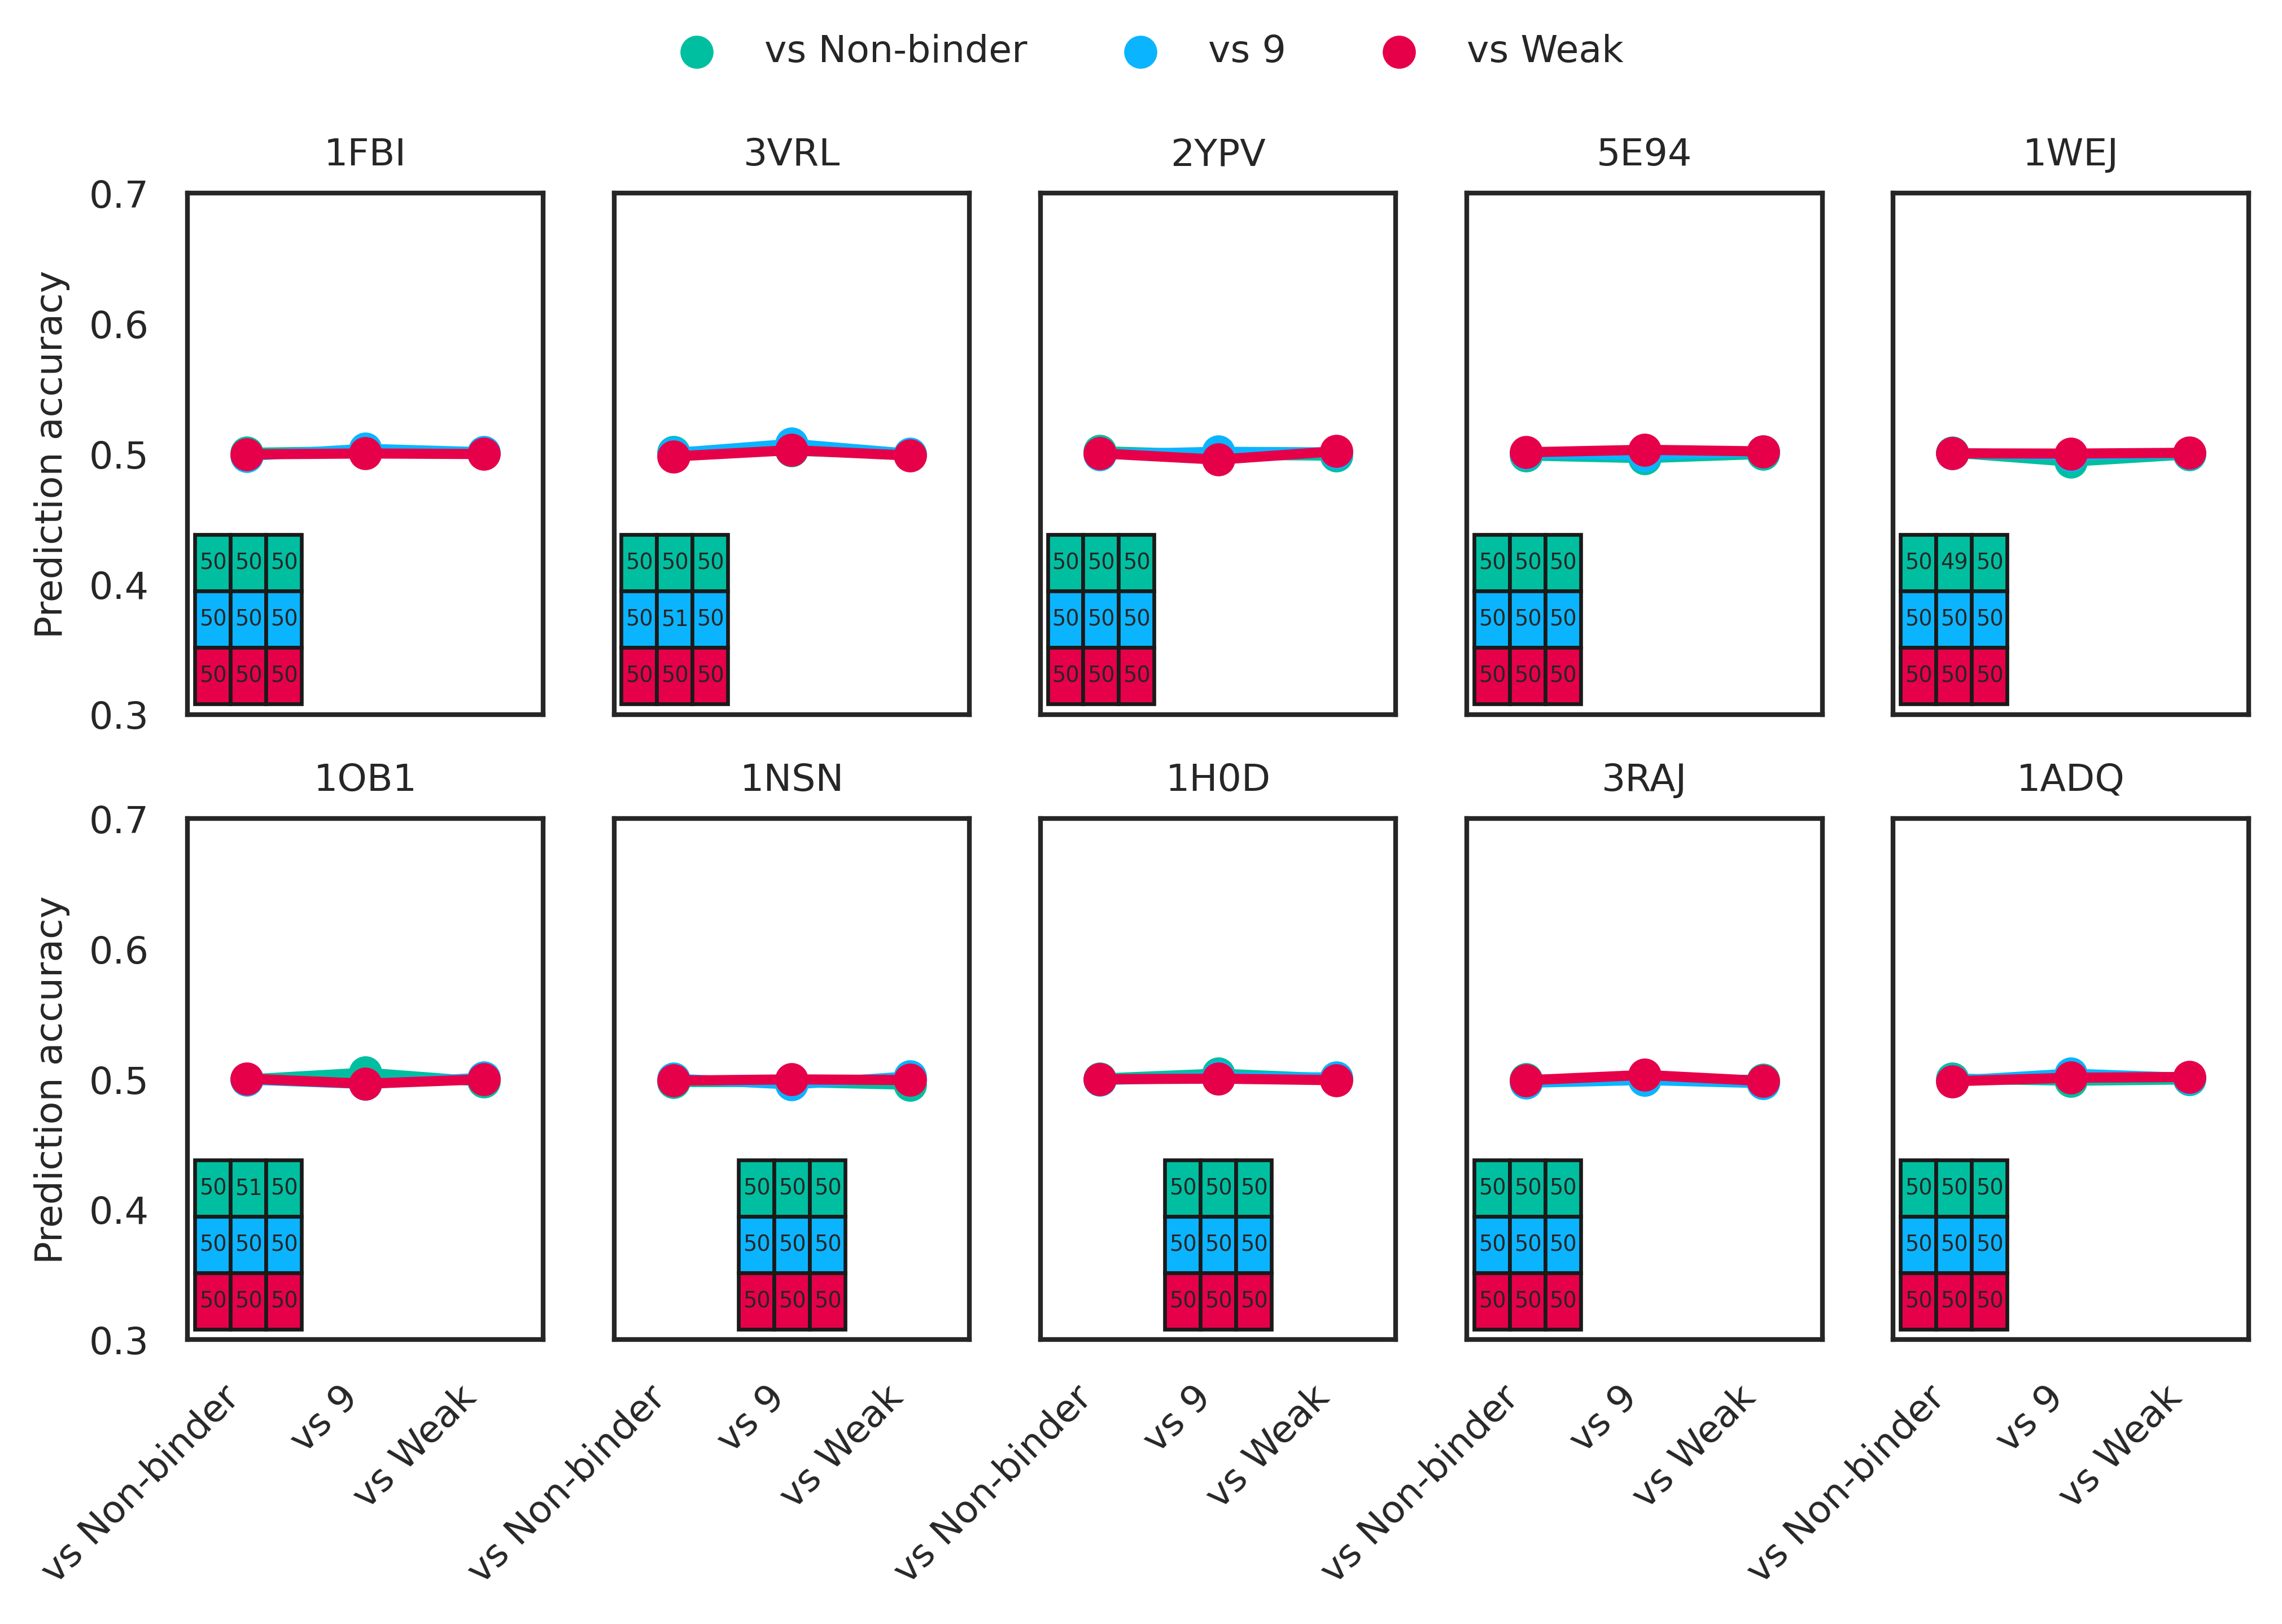

In [19]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, ag in enumerate(visualisations.PlotParams.order_antigens):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.3, 0.7)
    ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (
        df_i.groupby(["model_task", "test_task"])["acc"]
        .mean()
        .reset_index()
        .pivot(index="model_task", columns="test_task", values="acc")
        .loc[task_order][task_order]
        .values * 100).round().astype(int)
    table_values = np.where(table_values == 100, "", table_values)
    ax.table(
        cellText=table_values,
        loc=loc,
        colWidths=[0.1, 0.1, 0.1],
        cellColours=np.array([cmap for _ in range(3)]).transpose(),
    )

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

# fig.savefig("figures/1D1.svg")
fig.show()

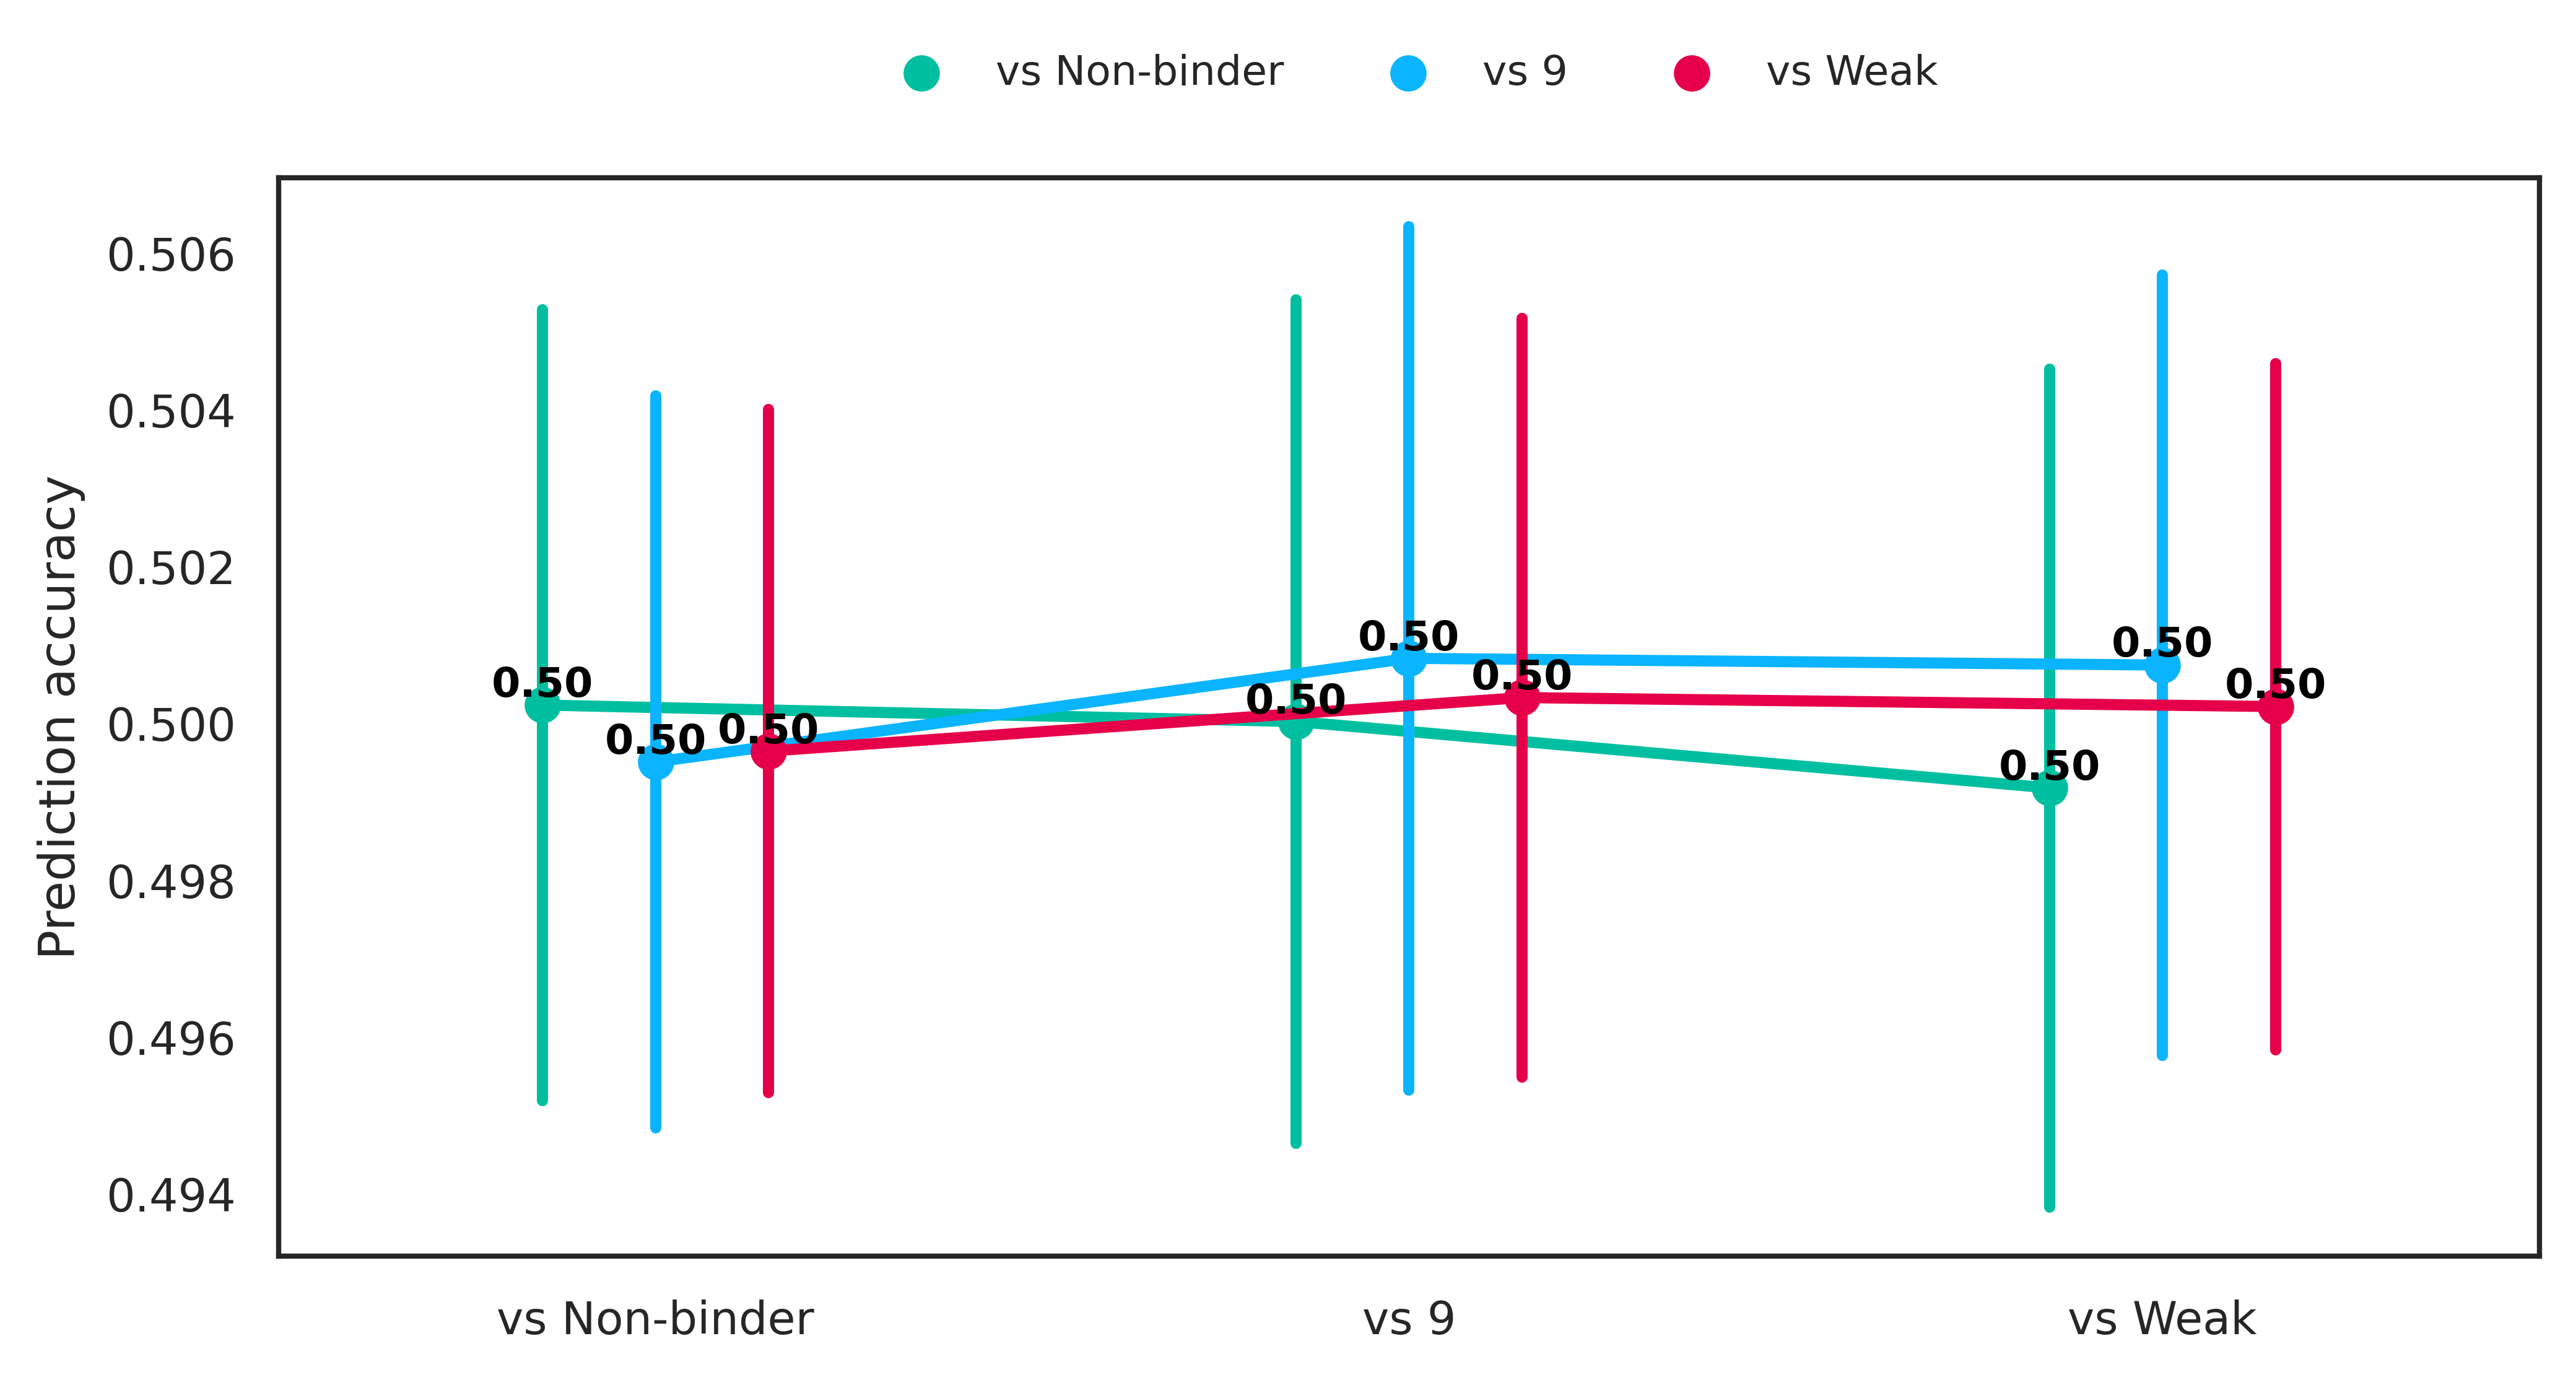

In [20]:
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

# fig.savefig("figures/1D2.svg")
fig.show()

In [21]:
(
    df_o.groupby(["model_task", "test_task"])["acc"].agg(["mean", "std", "size"])
    .round(3).reset_index()
    .query("model_task != test_task")
)

,model_task,test_task,mean,std,size
1,vs 1,vs 9,0.500,0.005,900
2,vs 1,vs Non-binder,0.500,0.005,900
3,vs 1,vs Weak,0.500,0.005,900
4,vs 9,vs 1,0.500,0.005,900
6,vs 9,vs Non-binder,0.500,0.005,100
7,vs 9,vs Weak,0.501,0.005,100
8,vs Non-binder,vs 1,0.500,0.005,900
9,vs Non-binder,vs 9,0.500,0.005,100
11,vs Non-binder,vs Weak,0.499,0.005,100
12,vs Weak,vs 1,0.501,0.005,900


In [22]:
# Computing the JSD for out-of-distribution testing
# We have the JSDs in the df, we can just add them.

df_o = pd.merge(df_o, df[["task", "jsd"]], left_on="task_1", right_on="task")
df_o = df_o.rename(columns={"jsd": "jsd_model"})
df_o = pd.merge(df_o, df[["task", "jsd"]], left_on="task_2", right_on="task")
df_o = df_o.rename(columns={"jsd": "jsd_test"})

# Add in-distribution performance from df
df_o = pd.merge(df_o, df[["task", "acc_closed"]], left_on="task_1", right_on="task")
df_o = df_o.rename(columns={"acc_closed": "acc_id"})

In [23]:
df_ood = df_o.query("model_task != test_task").copy()
df_ood["jsd_diff"] = df_ood["jsd_test"] - df_ood["jsd_model"]
df_ood["acc_diff"] = df_ood["acc"] - df_ood["acc_id"]

df_ood

,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id,model_task,test_task,task_x,jsd_model,task_y,jsd_test,task,acc_id,jsd_diff,acc_diff
1,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__0__42,0.498700,0.524400,0.498764,0.511261,3VRL,1v9,high_vs_95low,0_42,vs 9,vs Non-binder,ONE_VS_NINE__3VRL__auto__0__42,0.414933,HIGH_VS_95LOW__3VRL__auto__0__42,0.342429,ONE_VS_NINE__3VRL__auto__0__42,0.500501,-0.072503,-0.001801
2,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_LOOSER__3VRL__auto__0__42,0.494100,0.489600,0.494046,0.491813,3VRL,1v9,high_vs_looser,0_42,vs 9,vs Weak,ONE_VS_NINE__3VRL__auto__0__42,0.414933,HIGH_VS_LOOSER__3VRL__auto__0__42,0.398217,ONE_VS_NINE__3VRL__auto__0__42,0.500501,-0.016716,-0.006401
3,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_ONE__3VRL__1NSN__0__42,0.501800,0.540800,0.501670,0.520500,3VRL,1v9,1v1,0_42,vs 9,vs 1,ONE_VS_NINE__3VRL__auto__0__42,0.414933,ONE_VS_ONE__3VRL__1NSN__0__42,0.378568,ONE_VS_NINE__3VRL__auto__0__42,0.500501,-0.036365,0.001299
4,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_ONE__3VRL__3RAJ__0__42,0.496100,0.496600,0.496104,0.496352,3VRL,1v9,1v1,0_42,vs 9,vs 1,ONE_VS_NINE__3VRL__auto__0__42,0.414933,ONE_VS_ONE__3VRL__3RAJ__0__42,0.411863,ONE_VS_NINE__3VRL__auto__0__42,0.500501,-0.003069,-0.004401
5,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_ONE__3VRL__5E94__0__42,0.506400,0.508400,0.506375,0.507385,3VRL,1v9,1v1,0_42,vs 9,vs 1,ONE_VS_NINE__3VRL__auto__0__42,0.414933,ONE_VS_ONE__3VRL__5E94__0__42,0.400382,ONE_VS_NINE__3VRL__auto__0__42,0.500501,-0.014550,0.005899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,HIGH_VS_LOOSER__1OB1__auto__0__42,ONE_VS_ONE__1OB1__1ADQ__0__42,0.506000,0.516200,0.505880,0.510988,1OB1,high_vs_looser,1v1,0_42,vs Weak,vs 1,HIGH_VS_LOOSER__1OB1__auto__0__42,0.401546,ONE_VS_ONE__1OB1__1ADQ__0__42,0.417740,HIGH_VS_LOOSER__1OB1__auto__0__42,0.502300,0.016195,0.003700
14395,HIGH_VS_LOOSER__1OB1__auto__0__42,ONE_VS_ONE__1OB1__1FBI__0__42,0.499900,0.533400,0.499906,0.516110,1OB1,high_vs_looser,1v1,0_42,vs Weak,vs 1,HIGH_VS_LOOSER__1OB1__auto__0__42,0.401546,ONE_VS_ONE__1OB1__1FBI__0__42,0.424507,HIGH_VS_LOOSER__1OB1__auto__0__42,0.502300,0.022962,-0.002400
14396,HIGH_VS_LOOSER__1OB1__auto__0__42,ONE_VS_ONE__1OB1__2YPV__0__42,0.497800,0.518800,0.497889,0.508129,1OB1,high_vs_looser,1v1,0_42,vs Weak,vs 1,HIGH_VS_LOOSER__1OB1__auto__0__42,0.401546,ONE_VS_ONE__1OB1__2YPV__0__42,0.402429,HIGH_VS_LOOSER__1OB1__auto__0__42,0.502300,0.000883,-0.004500
14397,HIGH_VS_LOOSER__1OB1__auto__0__42,ONE_VS_NINE__1OB1__auto__0__42,0.500601,0.518719,0.500580,0.509488,1OB1,high_vs_looser,1v9,0_42,vs Weak,vs 9,HIGH_VS_LOOSER__1OB1__auto__0__42,0.401546,ONE_VS_NINE__1OB1__auto__0__42,0.377202,HIGH_VS_LOOSER__1OB1__auto__0__42,0.502300,-0.024344,-0.001699


In [24]:
from scipy.stats import pearsonr
# Compute correlation coefficient, p-value and R2
# for jsd_diff and acc_diff per model_task and test_task
for i, df_g in df_ood.groupby(["model_task", "test_task"]):
    r, pval = pearsonr(df_g["jsd_diff"], df_g["acc_diff"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # R2
    r2 = r**2
    print(f"{i}: R2={r2:.2f}")

    # Record in dict
    df_ood.loc[df_g.index, "r"] = r
    df_ood.loc[df_g.index, "pval"] = pval
    df_ood.loc[df_g.index, "r2"] = r2

df_ood_summary = df_ood.groupby(["model_task", "test_task"])[["r", "pval", "r2"]].mean().round(2)
df_ood_summary

('vs 1', 'vs 9'): r=-0.00, p=0.89
('vs 1', 'vs 9'): R2=0.00
('vs 1', 'vs Non-binder'): r=0.08, p=0.01
('vs 1', 'vs Non-binder'): R2=0.01
('vs 1', 'vs Weak'): r=0.16, p=0.00
('vs 1', 'vs Weak'): R2=0.03
('vs 9', 'vs 1'): r=0.17, p=0.00
('vs 9', 'vs 1'): R2=0.03
('vs 9', 'vs Non-binder'): r=0.10, p=0.31
('vs 9', 'vs Non-binder'): R2=0.01
('vs 9', 'vs Weak'): r=0.14, p=0.17
('vs 9', 'vs Weak'): R2=0.02
('vs Non-binder', 'vs 1'): r=0.05, p=0.16
('vs Non-binder', 'vs 1'): R2=0.00
('vs Non-binder', 'vs 9'): r=-0.06, p=0.56
('vs Non-binder', 'vs 9'): R2=0.00
('vs Non-binder', 'vs Weak'): r=-0.03, p=0.74
('vs Non-binder', 'vs Weak'): R2=0.00
('vs Weak', 'vs 1'): r=0.10, p=0.00
('vs Weak', 'vs 1'): R2=0.01
('vs Weak', 'vs 9'): r=0.22, p=0.03
('vs Weak', 'vs 9'): R2=0.05
('vs Weak', 'vs Non-binder'): r=0.10, p=0.31
('vs Weak', 'vs Non-binder'): R2=0.01


r  pval    r2
model_task    test_task                      
vs 1          vs 9          -0.00  0.89  0.00
              vs Non-binder  0.08  0.01  0.01
              vs Weak        0.16  0.00  0.03
vs 9          vs 1           0.17  0.00  0.03
              vs Non-binder  0.10  0.31  0.01
              vs Weak        0.14  0.17  0.02
vs Non-binder vs 1           0.05  0.16  0.00
              vs 9          -0.06  0.56  0.00
              vs Weak       -0.03  0.74  0.00
vs Weak       vs 1           0.10  0.00  0.01
              vs 9           0.22  0.03  0.05
              vs Non-binder  0.10  0.31  0.01

In [25]:
df_ood_summary["text"] = df_ood_summary.apply(lambda x: f"r={x['r']}, p={x['pval']}, R2={x['r2']}", axis=1)
df_ood_summary.reset_index()

,model_task,test_task,r,pval,r2,text
0,vs 1,vs 9,-0.00,0.89,0.00,"r=-0.0, p=0.89, R2=0.0"
1,vs 1,vs Non-binder,0.08,0.01,0.01,"r=0.08, p=0.01, R2=0.01"
2,vs 1,vs Weak,0.16,0.00,0.03,"r=0.16, p=0.0, R2=0.03"
3,vs 9,vs 1,0.17,0.00,0.03,"r=0.17, p=0.0, R2=0.03"
4,vs 9,vs Non-binder,0.10,0.31,0.01,"r=0.1, p=0.31, R2=0.01"
5,vs 9,vs Weak,0.14,0.17,0.02,"r=0.14, p=0.17, R2=0.02"
6,vs Non-binder,vs 1,0.05,0.16,0.00,"r=0.05, p=0.16, R2=0.0"
7,vs Non-binder,vs 9,-0.06,0.56,0.00,"r=-0.06, p=0.56, R2=0.0"
8,vs Non-binder,vs Weak,-0.03,0.74,0.00,"r=-0.03, p=0.74, R2=0.0"
9,vs Weak,vs 1,0.10,0.00,0.01,"r=0.1, p=0.0, R2=0.01"
